# Финальное задание: решение

## Задача: предсказание победы по данным о первых 5 минутах игры

По первым 5 минутам игры предсказать, какая из команд победит: Radiant или Dire?

#### Описание признаков в таблице

- `match_id`: идентификатор матча в наборе данных
- `start_time`: время начала матча (unixtime)
- `lobby_type`: тип комнаты, в которой собираются игроки (расшифровка в `dictionaries/lobbies.csv`)
- Наборы признаков для каждого игрока (игроки команды Radiant — префикс `rN`, Dire — `dN`):
    - `r1_hero`: герой игрока (расшифровка в dictionaries/heroes.csv)
    - `r1_level`: максимальный достигнутый уровень героя (за первые 5 игровых минут)
    - `r1_xp`: максимальный полученный опыт
    - `r1_gold`: достигнутая ценность героя
    - `r1_lh`: число убитых юнитов
    - `r1_kills`: число убитых игроков
    - `r1_deaths`: число смертей героя
    - `r1_items`: число купленных предметов
- Признаки события "первая кровь" (first blood). Если событие "первая кровь" не успело произойти за первые 5 минут, то признаки принимают пропущенное значение
    - `first_blood_time`: игровое время первой крови
    - `first_blood_team`: команда, совершившая первую кровь (0 — Radiant, 1 — Dire)
    - `first_blood_player1`: игрок, причастный к событию
    - `first_blood_player2`: второй игрок, причастный к событию
- Признаки для каждой команды (префиксы `radiant_` и `dire_`)
    - `radiant_bottle_time`: время первого приобретения командой предмета "bottle"
    - `radiant_courier_time`: время приобретения предмета "courier" 
    - `radiant_flying_courier_time`: время приобретения предмета "flying_courier" 
    - `radiant_tpscroll_count`: число предметов "tpscroll" за первые 5 минут
    - `radiant_boots_count`: число предметов "boots"
    - `radiant_ward_observer_count`: число предметов "ward_observer"
    - `radiant_ward_sentry_count`: число предметов "ward_sentry"
    - `radiant_first_ward_time`: время установки командой первого "наблюдателя", т.е. предмета, который позволяет видеть часть игрового поля
- Итог матча (данные поля отсутствуют в тестовой выборке, поскольку содержат информацию, выходящую за пределы первых 5 минут матча)
    - `duration`: длительность
    - `radiant_win`: 1, если победила команда Radiant, 0 — иначе
    - Состояние башен и барраков к концу матча (см. описание полей набора данных)
        - `tower_status_radiant`
        - `tower_status_dire`
        - `barracks_status_radiant`
        - `barracks_status_dire`

### Подход 1: градиентный бустинг "в лоб"

In [1]:
import numpy as np
import pandas as pd

In [225]:
features = pd.read_csv('data/features.csv', index_col='match_id')
features.head(10)

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16.0,2449,0,4,1974,3,63
5,1430284186,1,11,5,1961,1461,19,0,1,6,...,4,4,0,-43.0,1453,0,512,2038,0,63
8,1430293701,1,8,3,967,1136,7,1,0,8,...,6,3,0,10.0,1968,0,1536,1983,12,63
9,1430299335,7,35,5,2117,1252,16,0,0,6,...,3,4,0,-15.0,4079,1,1540,0,63,0
11,1430308974,1,17,5,1527,906,10,0,1,7,...,3,4,0,26.0,3071,0,0,1572,0,63


Сформируем матрицу объектов-признаков:

In [226]:
X = features.iloc[:,:-6] ## Удаляем последение 6 признаков, являющиеся целевыми или результирующими признаками
y = features.iloc[:,-5]  ## Признак radiant_win является целевым признаком

#### Проведем предобработку данных:
1) Для начала избавимся от пропусков. Как можно заметить из 108 признаков 12 имею пропуски в данных. Самая очевидная причина: данные события не всегда происходили в первые пять минут игры, поэтому они просто не попали в выборку. Например такими признаками можно считать first_blood_player2, first_blood_team или radiant_flying_courier_time (см. описание выборки). В процессе обучения попробуем несколько способов заполнения пропусков заполнения пропусков, чтобы на практике выявить лучшие стратегии для того или иного алгоритма.

In [227]:
temp = X.count(axis = 0)                         # подсчитаем кол-во непустых признаков в стобцах
empty = temp.loc[temp != X.shape[0]]             # найдем "проблемные" признаки
empty = empty.apply(lambda x: X.shape[0] - x)    # подсчитаем кол-во пропусков
empty.sort_values(ascending=False)               # отсортируем

first_blood_player2            43987
radiant_flying_courier_time    27479
dire_flying_courier_time       26098
first_blood_player1            19553
first_blood_team               19553
first_blood_time               19553
dire_bottle_time               16143
radiant_bottle_time            15691
radiant_first_ward_time         1836
dire_first_ward_time            1826
radiant_courier_time             692
dire_courier_time                676
dtype: int64

In [228]:
y = y.as_matrix()

X_1 = X.fillna(2**64).astype('float32').as_matrix()                                # Для решающих деревьев
X_2 = X.fillna(X.mean(axis = 0)).astype('float32').as_matrix()                      # Для других
X_3 = X.fillna(X.median(axis = 0)).astype('float32').as_matrix()
X_4 = X.fillna(0).astype('float32').as_matrix()                                     # Для регрессии
X_5 = X.fillna(X.interpolate(method='linear',order = 5)).astype('float32') 
X_5 = X_5.fillna(2**64).astype('float32').as_matrix() 

2) Теперь, имея готовые выборки, будем использовать градиентный бустинг над решающими деревьями. Проверка обобщающей способности алгоритма будет проводиться с помощью auc-roc метрики. Будем обучаться по всем нашим выборкам с кол-во деревьев 10,20,30, 60, 120, 180. Оенку качества будем проводить на кросс-валиадции по 5 блокам.

In [8]:
import time
import datetime
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from scipy import interp
import matplotlib.pyplot as plt

ОСТОРОЖНО, алгоритм работает очень очень и очень долго.

Started for 10.00
Time elapsed : 0:00:55.9194


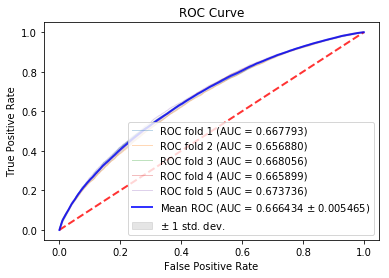

Started for 20.00
Time elapsed : 0:01:35.9301


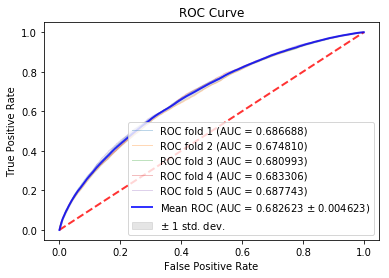

Started for 30.00
Time elapsed : 0:02:44.0117


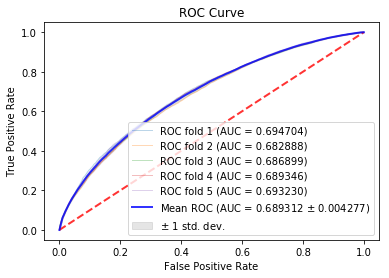

Started for 60.00
Time elapsed : 0:05:42.6961


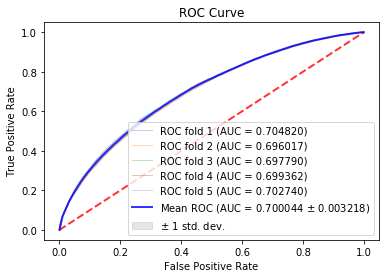

Started for 120.00
Time elapsed : 0:10:54.8897


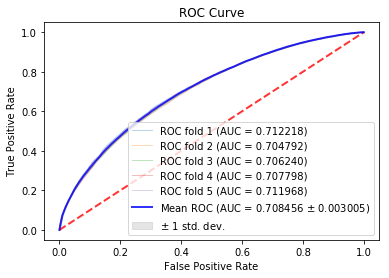

Started for 180.00
Time elapsed : 0:18:58.1383


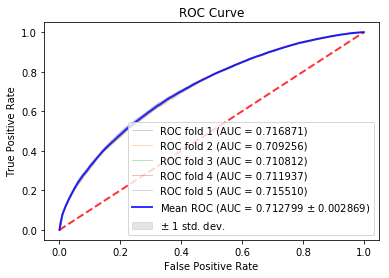

Started for 10.00
Time elapsed : 0:01:18.6411


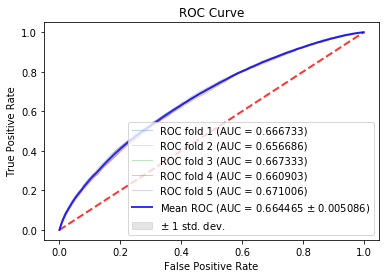

Started for 20.00
Time elapsed : 0:02:33.2246


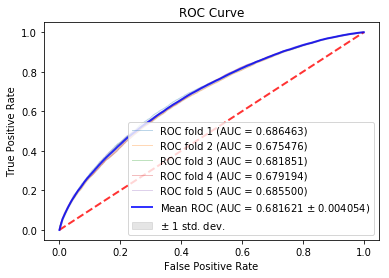

Started for 30.00
Time elapsed : 0:03:42.2294


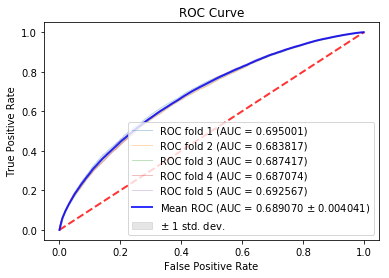

Started for 60.00
Time elapsed : 0:07:09.5267


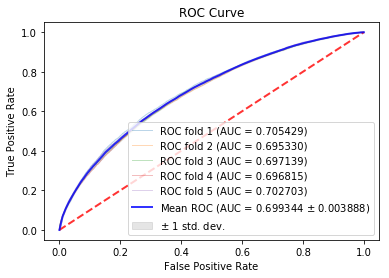

Started for 120.00
Time elapsed : 0:14:08.9128


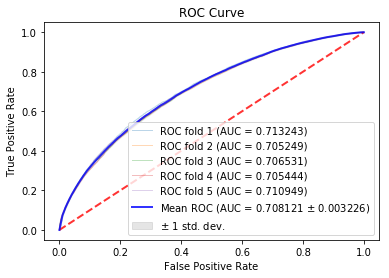

Started for 180.00
Time elapsed : 0:19:44.2398


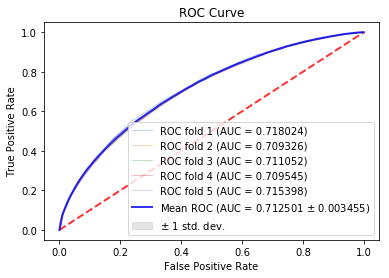

Started for 10.00
Time elapsed : 0:01:09.1257


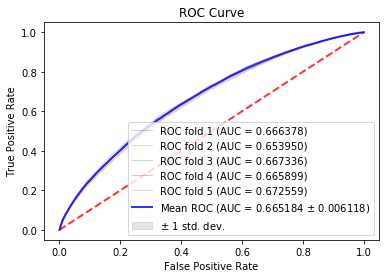

Started for 20.00
Time elapsed : 0:02:12.3476


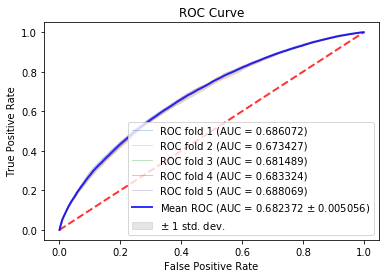

Started for 30.00
Time elapsed : 0:03:18.7339


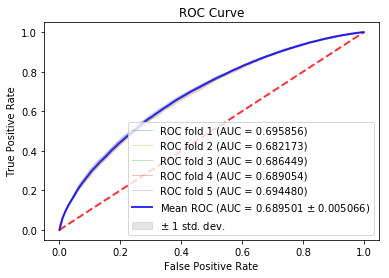

Started for 60.00
Time elapsed : 0:06:48.4064


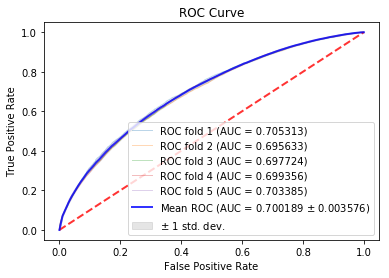

Started for 120.00
Time elapsed : 0:13:34.3448


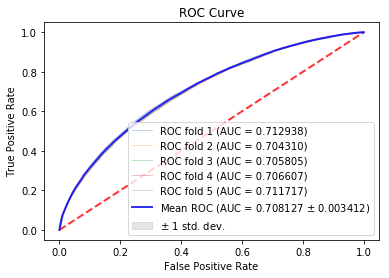

Started for 180.00
Time elapsed : 0:18:37.2045


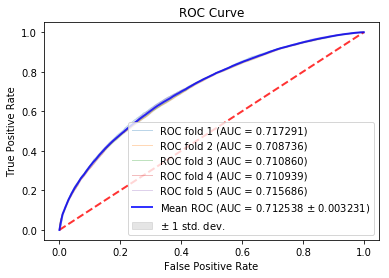

Started for 10.00
Time elapsed : 0:00:41.5749


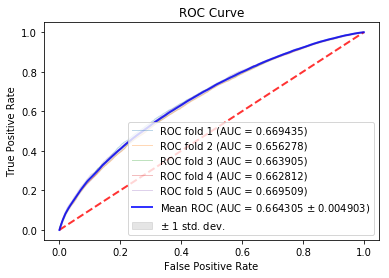

Started for 20.00
Time elapsed : 0:01:19.6270


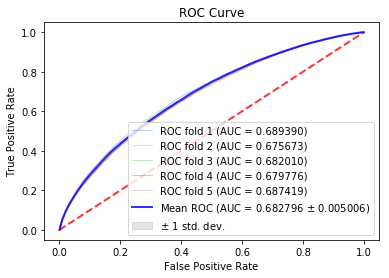

Started for 30.00
Time elapsed : 0:02:11.3605


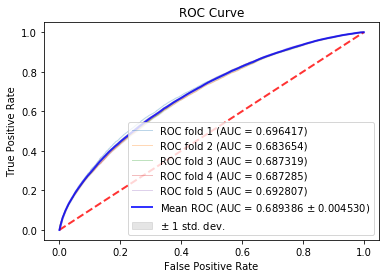

Started for 60.00
Time elapsed : 0:04:24.5231


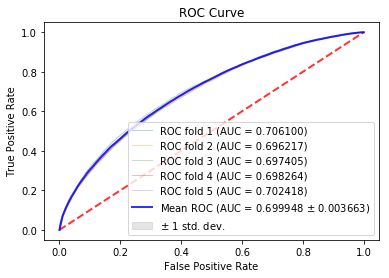

Started for 120.00
Time elapsed : 0:08:59.0373


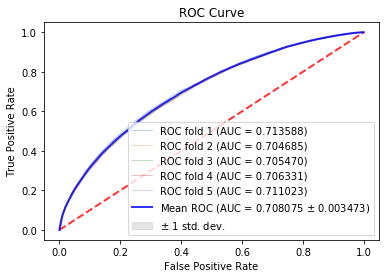

Started for 180.00
Time elapsed : 0:13:46.7404


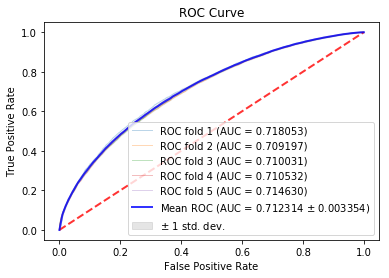

Started for 10.00
Time elapsed : 0:00:53.3936


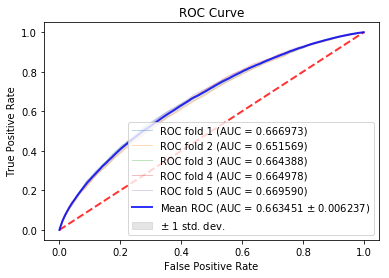

Started for 20.00
Time elapsed : 0:01:39.4320


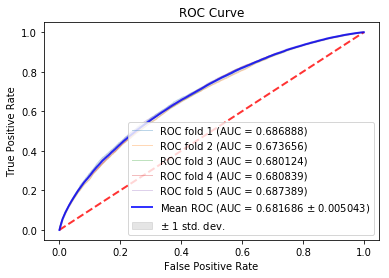

Started for 30.00
Time elapsed : 0:02:26.9451


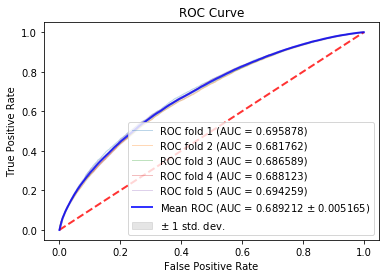

Started for 60.00
Time elapsed : 0:04:42.0337


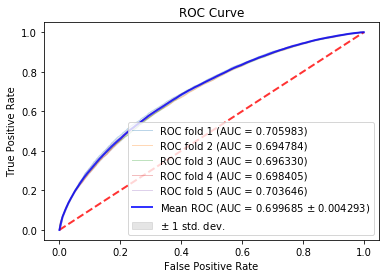

Started for 120.00
Time elapsed : 0:08:46.9960


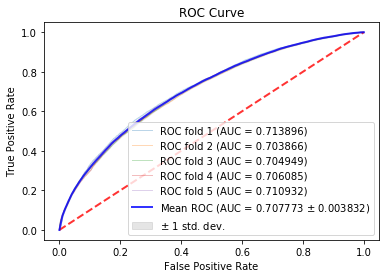

Started for 180.00
Time elapsed : 0:13:50.1801


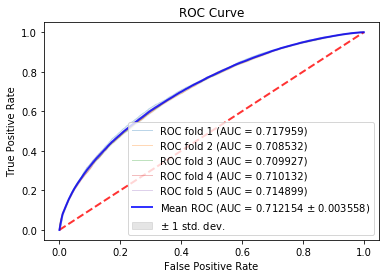

In [22]:
k = KFold(n_splits=5, shuffle=True, random_state=241)

for i in [X_1, X_2, X_3, X_4, X_5]:    
    for j in [10,20,30, 60, 120, 180]: 
        
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)
        index = 0
        
        print("Started for {:.2f}".format(j))
        start_time = datetime.datetime.now()
        gbc = GradientBoostingClassifier(n_estimators=j, verbose=False, random_state=241)
        
        for train_index, test_index in k.split(i):
            index += 1
            X_train, X_test = i[train_index], i[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            y_pred = gbc.fit(X_train, y_train).predict_proba(X_test)[:, 1]
              
            fpr, tpr, thresholds = roc_curve(y_test, y_pred)
            
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            plt.plot(fpr, tpr, lw=1, alpha=0.3,
                     label='ROC fold %d (AUC = %0.6f)' % (index, roc_auc))

        print('Time elapsed : {:.12s}'.format(str(datetime.datetime.now() - start_time)))     
        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        plt.plot(mean_fpr, mean_tpr, color='b',
                 label=r'Mean ROC (AUC = %0.6f $\pm$ %0.6f)' % (mean_auc, std_auc),
                 lw=2, alpha=.8)

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                         label=r'$\pm$ 1 std. dev.')

        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.show()
            

Имеем лучшее среднее качество: 0.712799 (1), 0.712501 (2), 0.712538(3), 0.712314(4), 0.712154(5)

#####  Краткие итоги
1. 12 признаков имеют пропуски в данных. Имена были выведены выше. Основной причиной появления пропусков могло быть отсутствие тех или иных событий в первые 5 минут игры.
2. Признак radiant_win является целевым признаком, определяющим какая из команд одержала победу.
3. Подробно описано выше.
4. Исходя из исследований выше, с увелечением количества деревьев растет и качество алгоритма. Для ускорения обучения можно уменьшить обучающую выборку или ограничить некоторые гиперпараметры деревьев, такие как глубина дерева, количество листьев и т.д.
5. Медленно и похоже не так эффективно, как хотелось бы

### Подход 2: Логистическая регрессия

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [229]:
ss = StandardScaler()
X_4 = ss.fit_transform(X_4)

Теперь снова пробовть разные варианты заполнения не будем. Но для начала разделим нашу выборку на несколько частей.

In [230]:
parameter = [0.001,0.01,0.1,1,10,100]
k = KFold(n_splits=5, shuffle=True, random_state=241)

for i in [X_4]:
    start_time = datetime.datetime.now()
    for j in parameter: 
        aucs = [] 
        print("Started for {:.4f}".format(j))
        LR = LogisticRegression(C = j, random_state = 241)
        for train_index, test_index in k.split(i):
            X_train, X_test = i[train_index], i[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            y_pred = LR.fit(X_train, y_train).predict_proba(X_test)[:,1]
              
            fpr, tpr, thresholds = roc_curve(y_test, y_pred)
            roc_auc = auc(fpr, tpr)   
            aucs.append(roc_auc)
        
        mean_auc = np.mean(aucs)
        print('Mean auc: {:.12f}'.format(mean_auc))

    print('Time elapsed : {:.12s}'.format(str(datetime.datetime.now() - start_time)))

Started for 0.0010
Mean auc: 0.716180276030
Started for 0.0100
Mean auc: 0.716341470663
Started for 0.1000
Mean auc: 0.716310053999
Started for 1.0000
Mean auc: 0.716306590005
Started for 10.0000
Mean auc: 0.716306350541
Started for 100.0000
Mean auc: 0.716306267895
Time elapsed : 0:01:16.5478


Удалим категориальные признаки из выборки, заполним пропуски, нормируем.

In [231]:
labels = ['lobby_type', 'r1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero', 'd1_hero', 'd2_hero',
          'd3_hero', 'd4_hero', 'd5_hero']
X_no_cat = X.drop(labels, axis = 1)
X_no_cat = X_no_cat.fillna(0).astype('float32').as_matrix()
X_no_cat = ss.fit_transform(X_no_cat)

In [232]:
parameter = [0.001,0.01,0.1,1,10,100]
k = KFold(n_splits=5, shuffle=True, random_state=241)


for i in [X_no_cat]:
    start_time = datetime.datetime.now()
    for j in parameter: 
        print("Started for {:.4f}".format(j))
        aucs = []         
        LR = LogisticRegression(C = j, random_state = 241)
        
        for train_index, test_index in k.split(i):
            X_train, X_test = i[train_index], i[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            y_pred = LR.fit(X_train, y_train).predict_proba(X_test)[:,1]
              
            fpr, tpr, thresholds = roc_curve(y_test, y_pred)
            roc_auc = auc(fpr, tpr)   
            aucs.append(roc_auc)
        
        mean_auc = np.mean(aucs)
        print('Mean auc: {:.12f}'.format(mean_auc))

    print('Time elapsed : {:.12s}'.format(str(datetime.datetime.now() - start_time)))

Started for 0.0010
Mean auc: 0.716235592068
Started for 0.0100
Mean auc: 0.716400953834
Started for 0.1000
Mean auc: 0.716373783411
Started for 1.0000
Mean auc: 0.716370738898
Started for 10.0000
Mean auc: 0.716370452817
Started for 100.0000
Mean auc: 0.716370520635
Time elapsed : 0:01:13.2422


Методом "мешка слов" добавим категориальные признаки.

In [234]:
# N — количество различных героев в выборке
X_pick = np.zeros((X.shape[0], 112))

for i, match_id in enumerate(X.index):
    for p in range(5):
        X_pick[i, X.loc[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick[i, X.loc[match_id, 'd%d_hero' % (p+1)]-1] = -1

Соединим созданные признаки с изначальной матрицей и проверим, что получилось.

In [235]:
X_final = np.hstack((X_no_cat, X_pick)).astype('float32')
X_final.shape

(97230, 203)

In [351]:
parameter = np.linspace(0.01, 0.1, 5)
k = KFold(n_splits=5, shuffle=True, random_state=241)

start_time = datetime.datetime.now()
for j in parameter: 
    print("Started for {:.4f}".format(j))
    aucs = []         
    LR = LogisticRegression(C = j, random_state = 241)

    for train_index, test_index in k.split(X_final):
        X_train, X_test = X_final[train_index], X_final[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        y_pred = LR.fit(X_train, y_train).predict_proba(X_test)[:,1]

        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)   
        aucs.append(roc_auc)

    mean_auc = np.mean(aucs)
    print('Mean auc: {:.12f} MIN: {:.12f} MAX: {:.12f}'.format(mean_auc,min(aucs),max(aucs)))

print('Time elapsed : {:.12s}'.format(str(datetime.datetime.now() - start_time)))

Started for 0.0100
Mean auc: 0.751735954731 MIN: 0.749440562817 MAX: 0.755115888511
Started for 0.0325
Mean auc: 0.751938350691 MIN: 0.749580580935 MAX: 0.755190281372
Started for 0.0550
Mean auc: 0.751944310795 MIN: 0.749578113889 MAX: 0.755179638692
Started for 0.0775
Mean auc: 0.751940965372 MIN: 0.749568235115 MAX: 0.755167841731
Started for 0.1000
Mean auc: 0.751937491895 MIN: 0.749562252792 MAX: 0.755157580282
Time elapsed : 0:02:02.9269


#####  Краткие итоги
1. 0.716341470663 можно считать лучшим качеством над всеми исходными признаками, оно выше градиентного бустинга и алгоритм гораздо быстрее работает. Все таки градиантный бустринг - композиция огромного количества алгоримов, для этого необходимо больше затрат ресурсов.
2. Качество немного улучшилось 0.716400953834. Алгоритм просто не умеет интерпретировать категориальные признаки (он работает с ними как с обычными признаками), именно поэтому нужен метод мешка слов.
3. 112 героев
4. 0.751937491895, что заметно лучше предыдущих. Однозначно выбор героя влияет на результат игры.
5. 0.751944310795 MIN: 0.749578113889 MAX: 0.755179638692 - Лучший полученный результат.

### Подготовка ответа для Kaggle

Загрузим тестовую выборку и используем лучший из найденных нами алгоритмов для предсказания вероятности. 

In [333]:
features = pd.read_csv('data/features_test.csv', index_col='match_id')
features.head(10)

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
match_id,,,,,,,,,,,,,,,,,,,,,
6,1430287923,0,93,4,1103,1089,8,0,1,9,...,0,12.0,247.0,-86.0,272.0,3,4,2,0,118.0
7,1430293357,1,20,2,556,570,1,0,0,9,...,2,-29.0,168.0,-54.0,NaN,3,2,2,1,16.0
10,1430301774,1,112,2,751,808,1,0,0,13,...,1,-22.0,46.0,-87.0,186.0,1,3,3,0,-34.0
13,1430323933,1,27,3,708,903,1,1,1,11,...,2,-49.0,30.0,-89.0,210.0,3,4,2,1,-26.0
16,1430331112,1,39,4,1259,661,4,0,0,9,...,0,36.0,180.0,-86.0,180.0,1,3,2,1,-33.0
18,1430334264,0,97,5,2067,1549,15,0,0,8,...,0,243.0,260.0,-55.0,279.0,3,5,2,0,34.0
19,1430334995,1,97,4,1862,1487,24,0,1,5,...,0,17.0,NaN,-84.0,209.0,4,3,2,1,-32.0
24,1430349466,1,106,5,1991,1983,19,2,0,10,...,0,-25.0,73.0,-87.0,NaN,2,5,2,1,-35.0
33,1430366484,1,57,2,517,500,0,0,1,9,...,1,119.0,76.0,-86.0,237.0,1,3,2,2,NaN


Создаем "мешок слов":

In [334]:
X_pick = np.zeros((features.shape[0], 112))

for i, match_id in enumerate(features.index):
    for p in range(5):
        X_pick[i, features.loc[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick[i, features.loc[match_id, 'd%d_hero' % (p+1)]-1] = -1

Чистим данные:

In [338]:
labels = ['lobby_type', 'r1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero', 'd1_hero', 'd2_hero',
          'd3_hero', 'd4_hero', 'd5_hero']
final = features.drop(labels, axis = 1)
final = final.fillna(0).astype('float32').as_matrix() 
final = ss.fit_transform(final)
final = np.hstack((final, X_pick)).astype('float32')

In [352]:
LR = LogisticRegression(C = 0.0550, random_state = 241)
LR.fit(X_final, y)

LogisticRegression(C=0.055, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=241, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [353]:
y_pred = LR.predict_proba(final)[:,1]
y_pred

array([ 0.8236729 ,  0.75595943,  0.18842314, ...,  0.23342949,
        0.62151144,  0.42836381])

In [354]:
ANSWERE = pd.DataFrame({'match_id': features.index, 'radiant_win': y_pred})

In [355]:
ANSWERE.to_csv("submission.csv", index=False)